In [73]:
from matplotlib.colors import ListedColormap
from numpy import dtype, ndarray, float16, int8
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np

## Data

In [74]:
def generate_data(seed: int = None) -> Tuple[ndarray, ndarray, ndarray, ndarray]:
    """
    Generating 2D points divided into 4 clusters.

    Parameters:
    - seed: Random seed for data generation.

    Returns:
    - Tuple containing X (data) and y (labels).
    """
    np.random.seed(seed)
    X: ndarray[float16, dtype[float16]] = np.vstack(
        [
            np.random.normal(loc=[1, 10], scale=[1, 1], size=(50, 2)),
            np.random.normal(loc=[10, 1], scale=[1, 1], size=(50, 2)),
            np.random.normal(loc=[1, 1], scale=[1, 1], size=(50, 2)),
            np.random.normal(loc=[10, 10], scale=[1, 1], size=(50, 2)),
        ]
    )
    y: ndarray[int8, dtype[int8]] = np.array([0] * 50 + [1] * 50 + [2] * 50 + [3] * 50)

    return (X, y)

In [75]:
def split_data(X: ndarray, y: ndarray) -> Tuple[ndarray, ndarray, ndarray, ndarray]:
    indices = np.random.permutation(len(X))
    split = int(0.8 * len(X))
    X_train, X_test = (
        X[indices[:split]],
        X[indices[split:]],
    )
    y_train, y_test = (
        y[indices[:split]],
        y[indices[split:]],
    )
    return (X_train, y_train, X_test, y_test)

In [76]:
X, y = generate_data()
X_train, y_train, X_test, y_test = split_data(X, y)

## Plotting the decision boundary

In [77]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    """
    Rysowanie regionów decyzyjnych klasyfikatora.

    Parametry:
    - X: Macierz cech danych.
    - y: Wektor etykiet klas danych.
    - classifier: Obiekt klasyfikatora z metodami fit i predict.
    - resolution: Rozdzielczość siatki.
    """
    # Setup marker generator and color map
    markers = ("s", "x", "o", "^", "v")
    colors = ("red", "blue", "lightgreen", "gray", "cyan")
    cmap = ListedColormap(colors[: len(np.unique(y))])

    # Tworzenie siatki punktów do pokolorowania
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution)
    )
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Rysowanie próbek klasy
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha=0.8,
            c=colors[idx],
            marker=markers[idx],
            label=f"Class {cl}",
            edgecolor="black",
        )

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(loc="upper left")
    plt.show()

## Perceptrony

### Perceptron Class

In [78]:
class Perceptron:
    def __init__(self, learning_rate: float = 0.1, n_iterations: int = 50):
        """
        Inicjalizacja perceptronu.

        Parametry:
        - learning_rate: Współczynnik uczenia (domyślnie 0.1).
        - n_iterations: Liczba iteracji treningowych (domyślnie 50).
        """
        self.learning_rate = learning_rate  # Ustawia współczynnik uczenia
        self.n_iterations = n_iterations  # Ustawia liczbę iteracji

    def train(self, X: ndarray, y: ndarray):
        """
        Uczenie perceptronu na podstawie danych treningowych.

        Parametry:
        - X: Macierz cech danych treningowych.
        - y: Wektor etykiet klas danych treningowych.
        """
        self.weights = np.zeros(X.shape[1] + 1)  # Inicjalizuje wagi
        for _ in range(self.n_iterations):  # Pętla ucząca
            for xi, target in zip(X, y):  # Pętla po danych treningowych
                prediction = self.predict(xi)  # Przewiduje klasę
                error = target - prediction  # Oblicza błąd
                self.weights[1:] += (
                    self.learning_rate * error * xi
                )  # Aktualizuje wagi cech
                self.weights[0] += self.learning_rate * error  # Aktualizuje bias

    def predict(self, X: ndarray) -> int:
        """
        Przewidywanie etykiety klasowej dla danych wejściowych.

        Parametry:
        - X: Dane wejściowe.

        Zwraca:
        - Wektor etykiet klasowych dla danych wejściowych.
        """
        activation = np.dot(X, self.weights[1:]) + self.weights[0]  # Oblicza aktywację
        return np.where(activation >= 0, 1, -1)  # Zwraca etykiety klas

    def accuracy(self, X: ndarray, y: ndarray) -> float:
        """
        Obliczenie dokładności klasyfikacji na podstawie danych wejściowych i prawdziwych etykiet.

        Parametry:
        - X: Dane wejściowe.
        - y: Prawdziwe etykiety klasowe.

        Zwraca:
        - Dokładność klasyfikacji jako ułamek.
        """
        predictions = self.predict(X)  # Przewiduje etykiety klas
        correct: int = np.sum(predictions == y)  # Liczy poprawne przewidywania
        total = len(y)  # Liczy łączną liczbę próbek
        return correct / total  # Zwraca dokładność klasyfikacji

#### One Versus the Rest

In [79]:
class OneVersusTheRest:
    def __init__(self, y: ndarray):

        self.perceptrons: List[Perceptron] = [
            Perceptron() for _ in range(len(np.unique(y)))
        ]

    def train(self, X_train: ndarray, y_train: ndarray):
        for i, perceptron in enumerate(self.perceptrons):
            y_train_perceptron = np.where(y_train == i, 1, -1)
            perceptron.train(X_train, y_train_perceptron)

    def predict(self, X_test: ndarray) -> int:
        predictions = np.array(
            [perceptron.predict(X_test) for perceptron in self.perceptrons]
        )
        return np.argmax(predictions, axis=0)

    def accuracy(self, X: ndarray, y: ndarray) -> float:
        predictions = self.predict(X)
        correct: int = np.sum(predictions == y)
        total = len(y)
        return correct / total

##### Wizualization for the One Versus the Rest (OVR) strategy.

Accuracy: 0.975


C:\Users\Olek Zima\AppData\Local\Temp\ipykernel_11552\2078707948.py:31: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


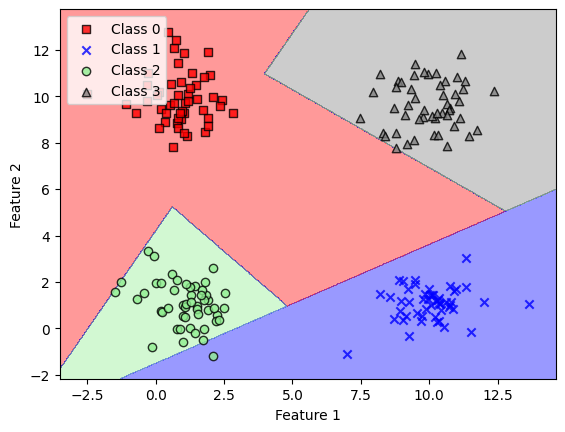

In [80]:
ovr = OneVersusTheRest(y)
ovr.train(X_train, y_train)
print(f"Accuracy: {ovr.accuracy(X_test, y_test)}")

plot_decision_regions(X, y, ovr)

#### One Versus One

In [81]:
from itertools import combinations


class OneVersusOne:
    def __init__(self, base_classifier, n_classes: int):
        """
        Inicjalizacja klasyfikatora One vs One.

        Parametry:
        - base_classifier: klasa klasyfikatora bazowego, np. Perceptron.
        - n_classes: liczba różnych klas w danych.
        """
        self.base_classifier = base_classifier
        self.n_classes = n_classes
        self.classifiers = []  # Lista klasyfikatorów dla każdej pary klas

    def train(self, X: np.ndarray, y: np.ndarray):
        """
        Trenowanie klasyfikatorów dla każdej pary klas.

        Parametry:
        - X: Macierz cech danych treningowych.
        - y: Wektor etykiet klas danych treningowych.
        """
        for class_pair in combinations(range(self.n_classes), 2):
            # Tworzenie maski dla obecnej pary klas
            mask = np.logical_or(y == class_pair[0], y == class_pair[1])
            X_pair = X[mask]
            y_pair = y[mask]
            # Przypisanie etykiet -1 i 1 dla klasyfikacji binarnej
            y_pair_binary = np.where(y_pair == class_pair[0], -1, 1)
            # Inicjalizacja i trenowanie klasyfikatora dla obecnej pary
            classifier = self.base_classifier()
            classifier.train(X_pair, y_pair_binary)
            self.classifiers.append((classifier, class_pair))

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Przewidywanie etykiet klasowych dla danych wejściowych.

        Parametry:
        - X: Dane wejściowe.

        Zwraca:
        - Wektor przewidywanych etykiet klasowych.
        """
        predictions = np.zeros((X.shape[0], self.n_classes))
        for classifier, classes in self.classifiers:
            prediction = classifier.predict(X)
            # Głosowanie: inkrementacja licznika dla wybranej klasy
            for i, p in enumerate(prediction):
                if p == 1:
                    predictions[i, classes[1]] += 1
                else:
                    predictions[i, classes[0]] += 1
        # Zwraca klasy z największą liczbą głosów
        return np.argmax(predictions, axis=1)

    def accuracy(self, X: ndarray, y: ndarray) -> float:
        predictions = self.predict(X)
        correct: int = np.sum(predictions == y)
        total = len(y)
        return correct / total

##### Wizualization for the One Versus One (OVO) strategy.

Accuracy: 0.975


C:\Users\Olek Zima\AppData\Local\Temp\ipykernel_11552\2078707948.py:31: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


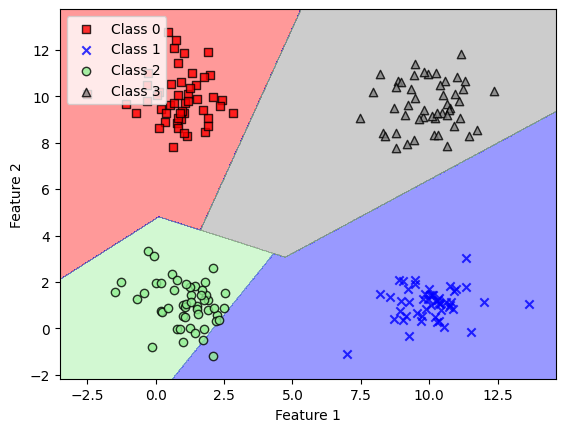

In [82]:
ovo = OneVersusOne(Perceptron, 4)
ovo.train(X_train, y_train)
print(f"Accuracy: {ovo.accuracy(X_test, y_test)}")

plot_decision_regions(X, y, ovo)

## Regression softmax

In [83]:
class SoftmaxRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations

    def fit(self, X, y):
        # Pobiera liczbę próbek, cech i klas
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        # Inicjalizuje wagi na zero
        self.weights = np.zeros((n_features, n_classes))

        # Inicjalizuje obciążenia na zera
        self.bias = np.zeros(n_classes)

        # Zamiana etykiet klas na wektory one-hot
        y_one_hot = self.one_hot(y)

        for _ in range(self.n_iterations):
            # Obliczenie modelu liniowego
            net_input = self.net_input(X)

            # Przewidywanie wartości za pomocą funkcji softmax
            y_predicted = self.softmax(net_input)

            # Obliczenie gradientu wag
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y_one_hot))

            # Obliczenie gradientu obciążeń
            db = (1 / n_samples) * np.sum(y_predicted - y_one_hot, axis=0)

            # Aktualizacja wag
            self.weights -= self.learning_rate * dw

            # Aktualizacja obciążeń
            self.bias -= self.learning_rate * db

    def predict(self, X):
        net_input = self.net_input(X)
        
        # Przewiduje wartości za pomocą funkcji softmax
        y_predicted = self.softmax(net_input)

        return np.argmax(y_predicted, axis=1)

    def predict_probability(self, X):
        net_input = self.net_input(X)
        
        # Przewiduje wartości za pomocą funkcji softmax
        y_predicted = self.softmax(net_input)

        return y_predicted

    def softmax(self, x):
        return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

    def net_input(self, X):
        return np.dot(X, self.weights) + self.bias

    def one_hot(self, y):
        n_values = np.max(y) + 1
        return np.eye(n_values)[y]

    def accuracy(self, X, y):
        """
        Obliczenie dokładności klasyfikacji na podstawie danych wejściowych i prawdziwych etykiet.

        Parametry:
        - X: Dane wejściowe.
        - y: Prawdziwe etykiety klasowe.

        Zwraca:
        - Dokładność klasyfikacji jako ułamek.
        """
        predictions = self.predict(X)  # Przewiduje etykiety klas
        correct = np.sum(predictions == y)  # Liczy poprawne przewidywania
        total = len(y)  # Liczy łączną liczbę próbek
        return correct / total  # Zwraca dokładność klasyfikacji

Accuracy: 0.975


C:\Users\Olek Zima\AppData\Local\Temp\ipykernel_11552\2078707948.py:31: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


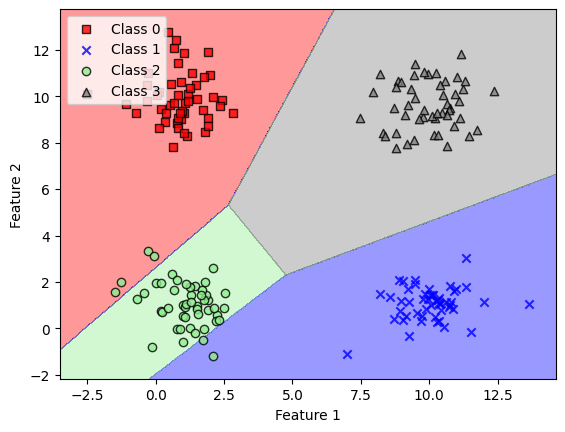

In [84]:
softmax = SoftmaxRegression()
softmax.fit(X_train, y_train)
print(f"Accuracy: {softmax.accuracy(X_test, y_test)}")

plot_decision_regions(X, y, softmax)